In [1]:
import logging
from binance.futures import Futures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import pandas as pd
import pandas_ta as ta
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from scipy import signal

In [2]:
#PARAMETERS
TIMEFRAME = "4h"
PAIR = "ETHUSDT"
DATA_WINDOW_LENGTH = 500
ROLLING_WINDOW_LENGTH = 6 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10

In [3]:
akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")

In [4]:
%%capture
config_logging(logging, logging.DEBUG)
futures_client = Client(key = akey, secret= asec)
# logging.info(futures_client.continuous_klines("BTCUSDT", 'PERPETUAL', '15m', limit=100));
klines = futures_client.continuous_klines(PAIR, 'PERPETUAL', TIMEFRAME, limit=DATA_WINDOW_LENGTH);

In [5]:
def process_klines(klines):

    df = pd.DataFrame(klines)
    df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df['open'] = pd.to_numeric(df['open'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['close'] = pd.to_numeric(df['close'])
    df['volume'] = pd.to_numeric(df['volume'])
    df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
    df['trades'] = pd.to_numeric(df['trades'])
    df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
    df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
    df['ignore'] = pd.to_numeric(df['ignore'])
    df.drop(['ignore'], axis=1, inplace=True)
    return df

In [6]:
df = process_klines(klines)

In [17]:
# closes_mean = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME), ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
# closes_std = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME), ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()
closes_mean = ta.ema(df.close, length=12)
closes_std = ta.stdev(df.close, length=12)
mean_std = closes_std.std()

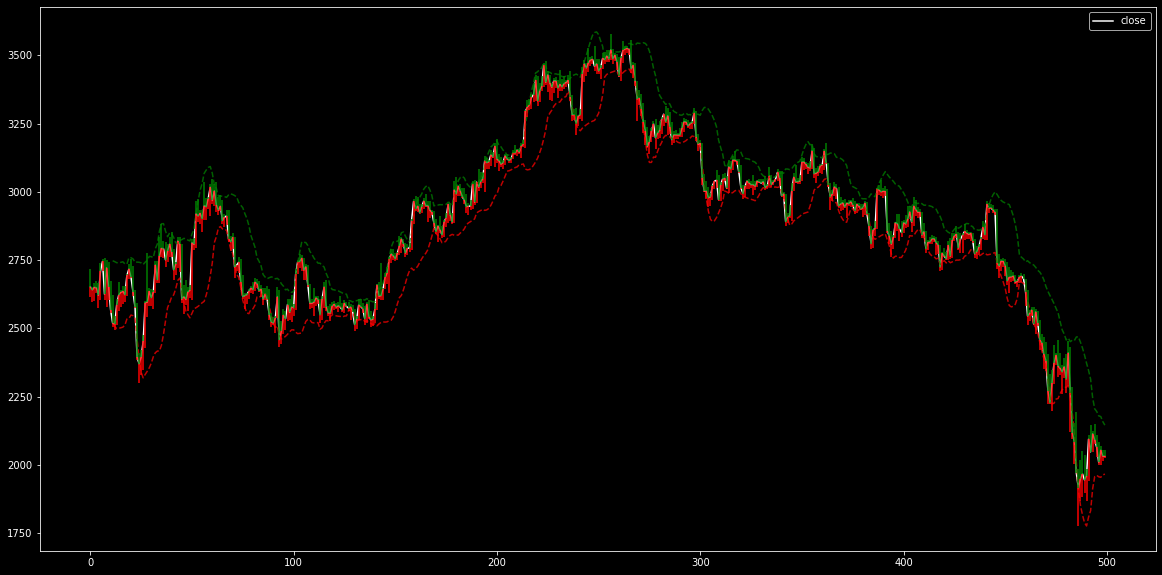

In [36]:
(fig, ax) = plt.subplots(figsize=(20,10))
ax.plot(df.close, label='close', color = "white")
# ax.plot(df.high, "-", label='high',  color = "green")
# ax.plot(df.low, "-", label='low',  color = "red")
# ax.plot(closes_mean, label='closes_mean', color = "magenta")
ax.plot(closes_mean + 1.618*closes_std, "--", color='green', alpha=0.75)
ax.plot(closes_mean - 1.618*closes_std, "--", color='red', alpha=0.75)
# plt.errorbar(df.index, df.close, yerr=(df.high - df.close), uplims=True, label='both limits (default)')
# plt.errorbar(df.index, df.close, yerr=(df.high - df.close), uplims=upperlimits, lolims=lowerlimits,
#              label='subsets of uplims and lolims')
uplimits = df.high >= df.close
lowlimits = df.low <= df.close
ax.vlines(df.index, ymin=df.close, ymax=df.high, color="green")
ax.vlines(df.index, ymin=df.low,ymax=df.close, color="red")
# ax.errorbar(df.index, df.close, yerr=np.abs(df.high - df.close), uplims=uplimits)
# ax.errorbar(df.index, df.close, yerr=np.abs(df.low - df.close), lolims=lowlimits)
ax.legend()

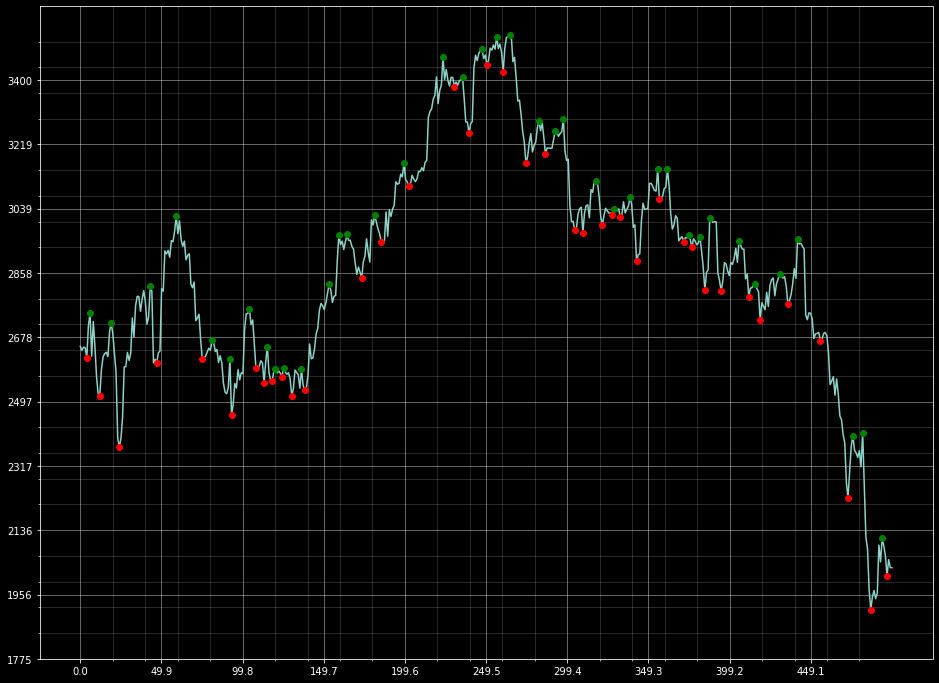

In [47]:
peak_indexes = signal.argrelextrema(df.close.values, np.greater, order=4)
peak_indexes = peak_indexes[0]

valley_indexes = signal.argrelextrema(df.close.values, np.less, order=4)
valley_indexes = valley_indexes[0]

# plot peaks
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

peak_x = peak_indexes
peak_y = df.close.values[peak_indexes]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
 
# plot valleys
valley_x = valley_indexes
valley_y = df.close.values[valley_indexes]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ymajor_ticks = np.arange(df.low.min(), df.high.max(), (df.high.max() - df.low.min())/10)
yminor_ticks = np.arange(df.low.min(), df.high.max(), (df.high.max() - df.low.min())/25)
xmajor_ticks = np.arange(df.index.min(), df.index.max(), (df.index.max() - df.index.min())/10)
xminor_ticks = np.arange(df.index.min(), df.index.max(), (df.index.max() - df.index.min())/25)

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor=True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.show()

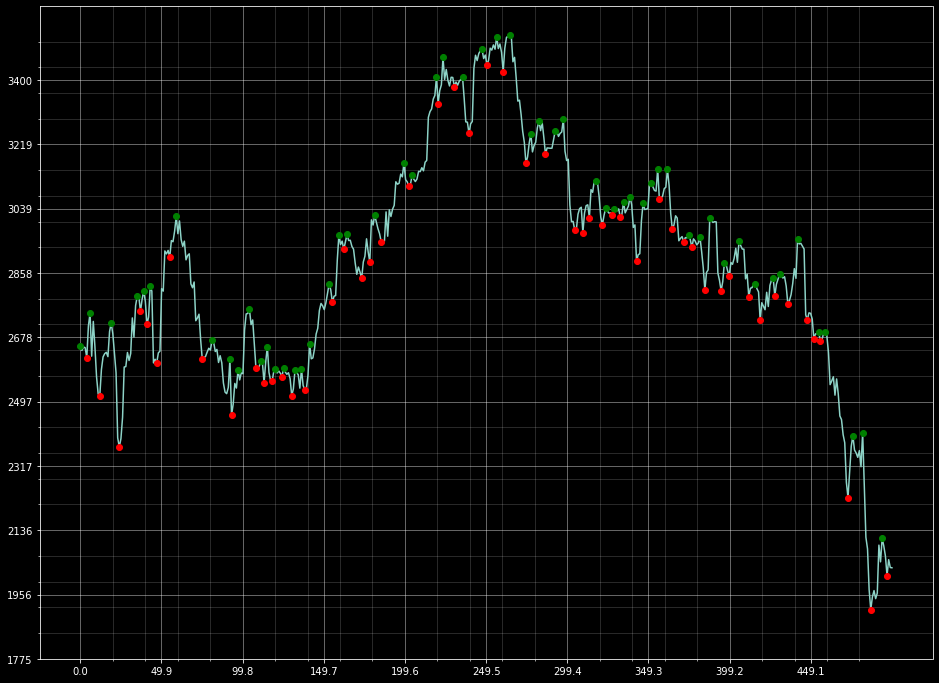

In [46]:
ilocs_min = signal.argrelextrema(df.close.values, np.less_equal, order=3)[0]
ilocs_max = signal.argrelextrema(df.close.values, np.greater_equal, order=3)[0]
peaks = df.close[ilocs_max]
valleys = df.close[ilocs_min]

(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

ax.plot(peaks, marker='o', linestyle="None", color='green', label="Peaks")
ax.plot(valleys, marker='o', linestyle="None", color='red', label="Peaks")
ymajor_ticks = np.arange(df.low.min(), df.high.max(), (df.high.max() - df.low.min())/10)
yminor_ticks = np.arange(df.low.min(), df.high.max(), (df.high.max() - df.low.min())/25)
xmajor_ticks = np.arange(df.index.min(), df.index.max(), (df.index.max() - df.index.min())/10)
xminor_ticks = np.arange(df.index.min(), df.index.max(), (df.index.max() - df.index.min())/25)

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor=True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.show()

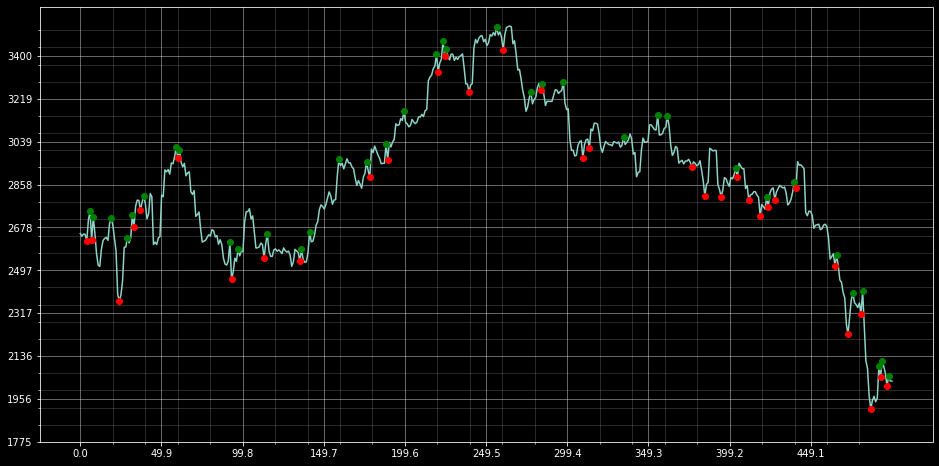

In [44]:
peaks, props_p = signal.find_peaks(df.close, threshold=mean_std/1.5)
valleys, props_v = signal.find_peaks(-df.close, threshold=mean_std/1.5)

(fig, ax) = plt.subplots(figsize=(16,8))
ax.plot(df.close)
ax.plot(df.close.iloc[peaks], marker='o', linestyle="None", color='green', label="Peaks")
ax.plot(df.close.iloc[valleys], marker='o', linestyle="None", color='red', label="Valleys")
ymajor_ticks = np.arange(df.low.min(), df.high.max(), (df.high.max() - df.low.min())/10)
yminor_ticks = np.arange(df.low.min(), df.high.max(), (df.high.max() - df.low.min())/25)
xmajor_ticks = np.arange(df.index.min(), df.index.max(), (df.index.max() - df.index.min())/10)
xminor_ticks = np.arange(df.index.min(), df.index.max(), (df.index.max() - df.index.min())/25)

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor=True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.show()


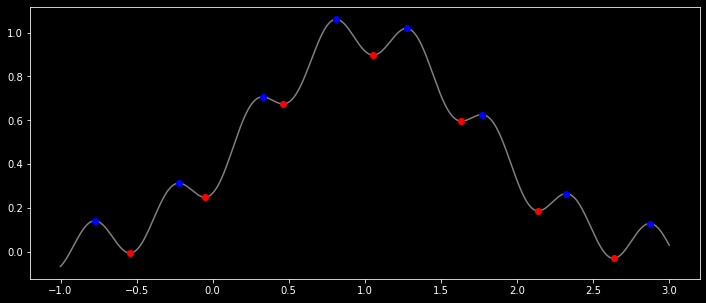

In [45]:

#example
import numpy as np
import matplotlib.pyplot as plt

# example data with peaks:
x = np.linspace(-1,3,1000)
data = -0.1*np.cos(12*x)+ np.exp(-(1-x)**2)

#     ___ detection of local minimums and maximums ___

a = np.diff(np.sign(np.diff(data))).nonzero()[0] + 1               # local min & max
b = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1         # local min
c = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1         # local max
# +1 due to the fact that diff reduces the original index number

# plot
plt.figure(figsize=(12, 5))
plt.plot(x, data, color='grey')
plt.plot(x[b], data[b], "o", label="min", color='r')
plt.plot(x[c], data[c], "o", label="max", color='b')
plt.show()

